<a href="https://colab.research.google.com/github/nebaraka/kaggle/blob/main/US_Wildfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and transform

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import datetime as dt
import math

In [2]:
pd.options.display.max_rows = 100

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install plotly -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 29.1 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [5]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


In [6]:
import plotly.express as px

pd.set_option("plotting.backend", "plotly")

In [7]:
conn = sqlite3.connect("gdrive/MyDrive/US_Wildfires/db.sqlite")

In [8]:
df_full = pd.read_sql_query("SELECT * from Fires;", conn)

In [9]:
conn.close()

In [10]:
df_full.shape

(1880465, 39)

In [11]:
df_full["MY_DATE"] = df_full.apply(lambda x: dt.datetime(x["FIRE_YEAR"], 1, 1) + 
                         dt.timedelta(int(x["DISCOVERY_DOY"] - 1)), axis=1)

In [12]:
df_full["MY_MONTH"] = df_full["MY_DATE"].apply(lambda x: x.month)

In [13]:
df_full["MY_DOW"] = df_full["MY_DATE"].apply(lambda x: pd.Timestamp(x).day_of_week)

In [14]:
df_full.shape

(1880465, 42)

In [15]:
df = df_full.sample(n=100000)

# EDA

#### How fires are distributed according to their causes

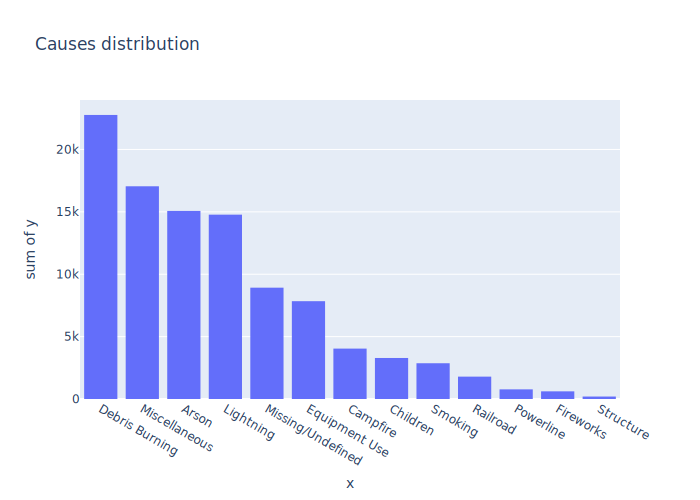

In [84]:
causes_counts = df["STAT_CAUSE_DESCR"].value_counts()
fig = px.histogram(x=causes_counts.index, y=causes_counts, 
                   title="Causes distribution")
fig.show("svg")

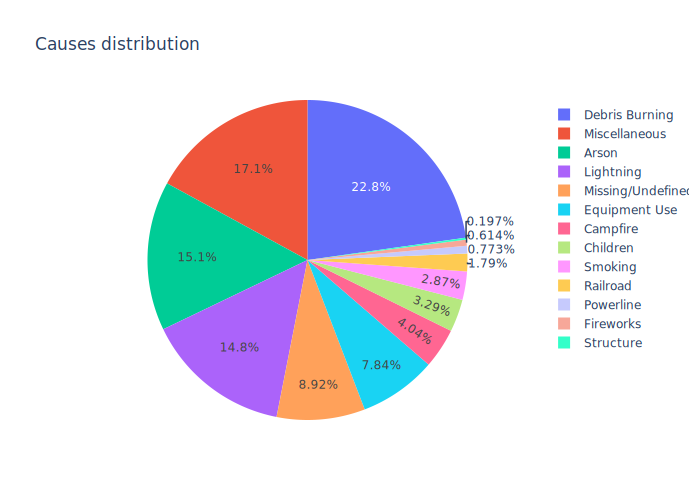

In [85]:
fig = px.pie(causes_counts, values=causes_counts, names=causes_counts.index, 
                   title="Causes distribution")
fig.show("svg")

#### Fire size distribution according to cause

In [86]:
fig = px.box(df, x="FIRE_SIZE", color="STAT_CAUSE_DESCR",
             title="Fire size distribution according to cause",
                 width=1400, height=600)
fig.show("svg")

#### How fire causes are distributed among states

In [87]:
from math import ceil

In [88]:
PART = 12
state_groups = [df["STATE"].unique()[PART*i:PART*(i+1)] for i in range(ceil(df["STATE"].nunique()/PART))]

In [89]:
figures = []
for num, state_group in enumerate(state_groups):
    fig = px.histogram(df[df["STATE"].apply(lambda x: x in state_group)], x="STAT_CAUSE_DESCR", 
                       color="STAT_CAUSE_DESCR", facet_col="STATE", facet_col_wrap=4, barmode="group",
                       title=f"Causes among states distribution. Group {num}",
                       width=1400, height=600)
    figures.append(fig)

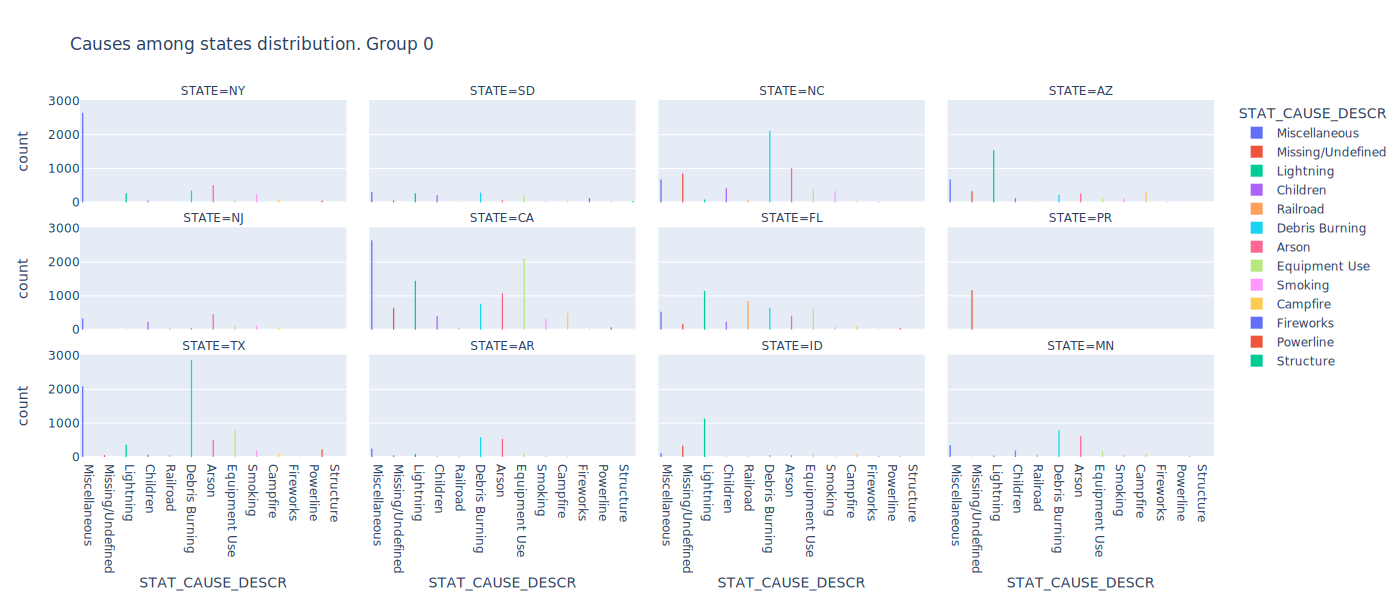

In [90]:
figures[0].show("svg")

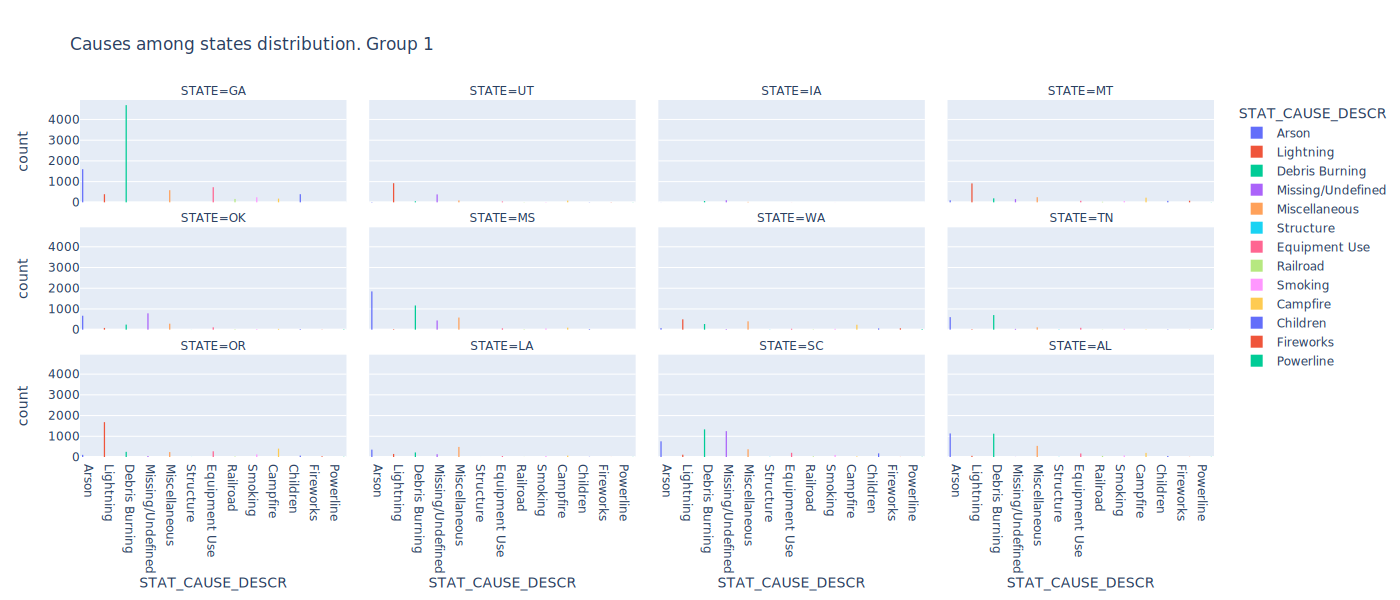

In [91]:
figures[1].show("svg")

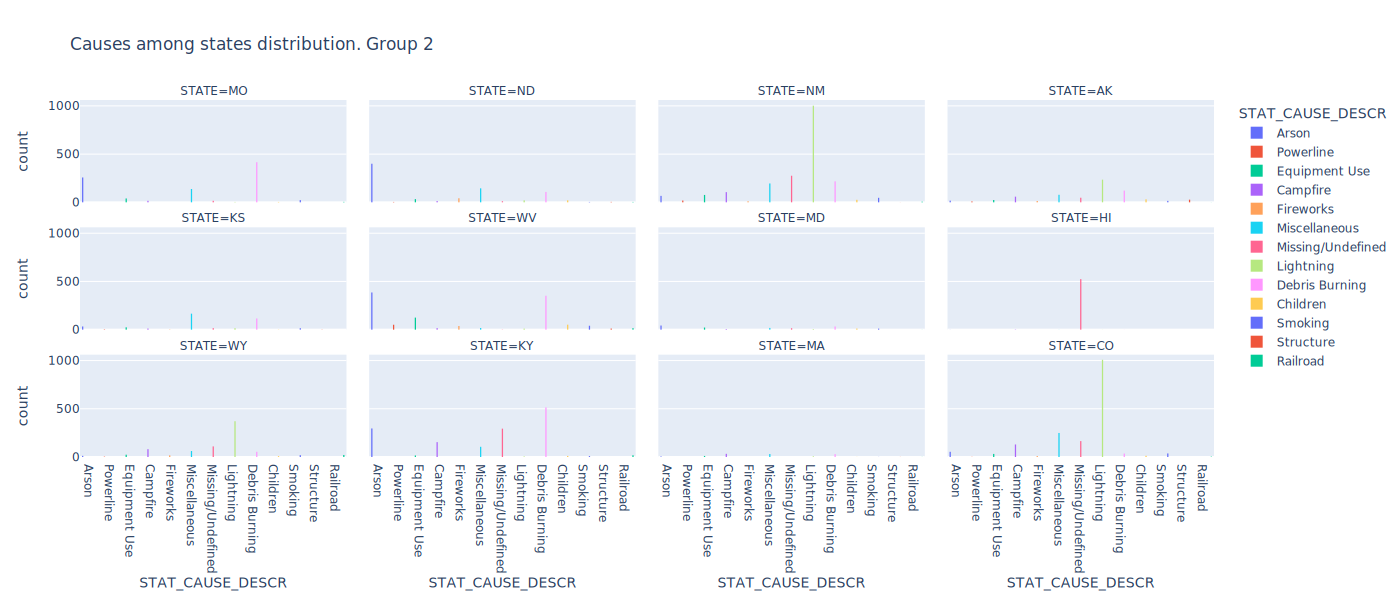

In [92]:
figures[2].show("svg")

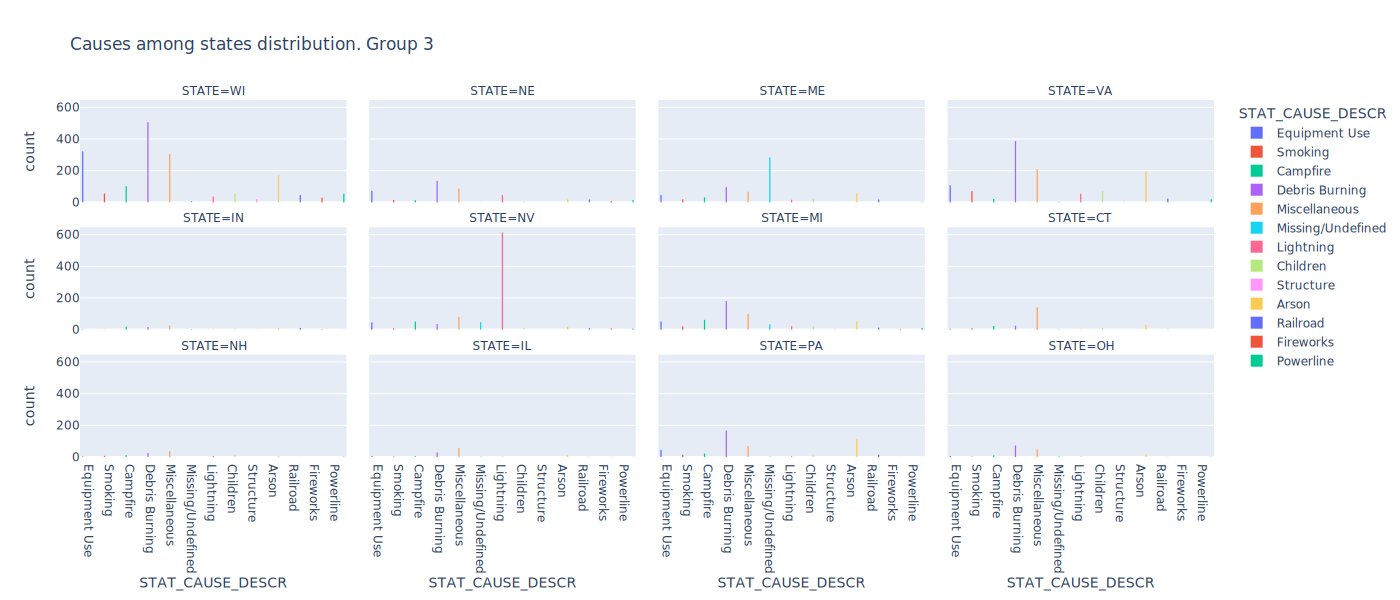

In [93]:
figures[3].show("svg")

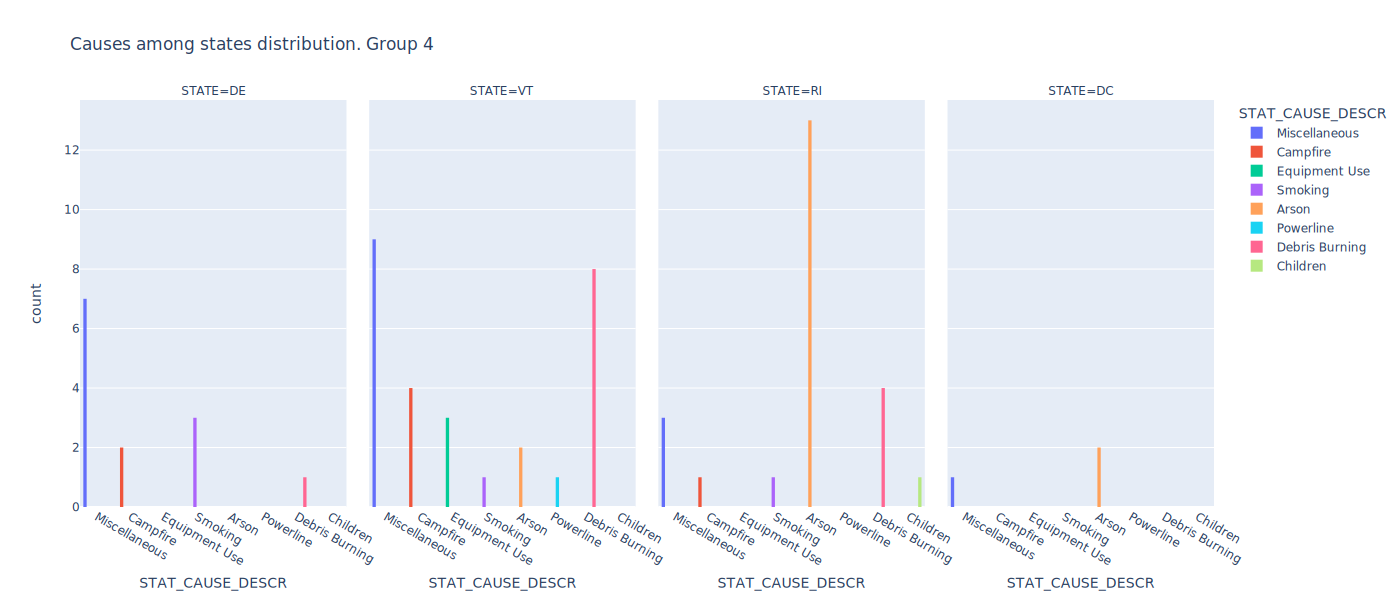

In [94]:
figures[4].show("svg")

#### How fire causes are distributed along DOY, months, DOW

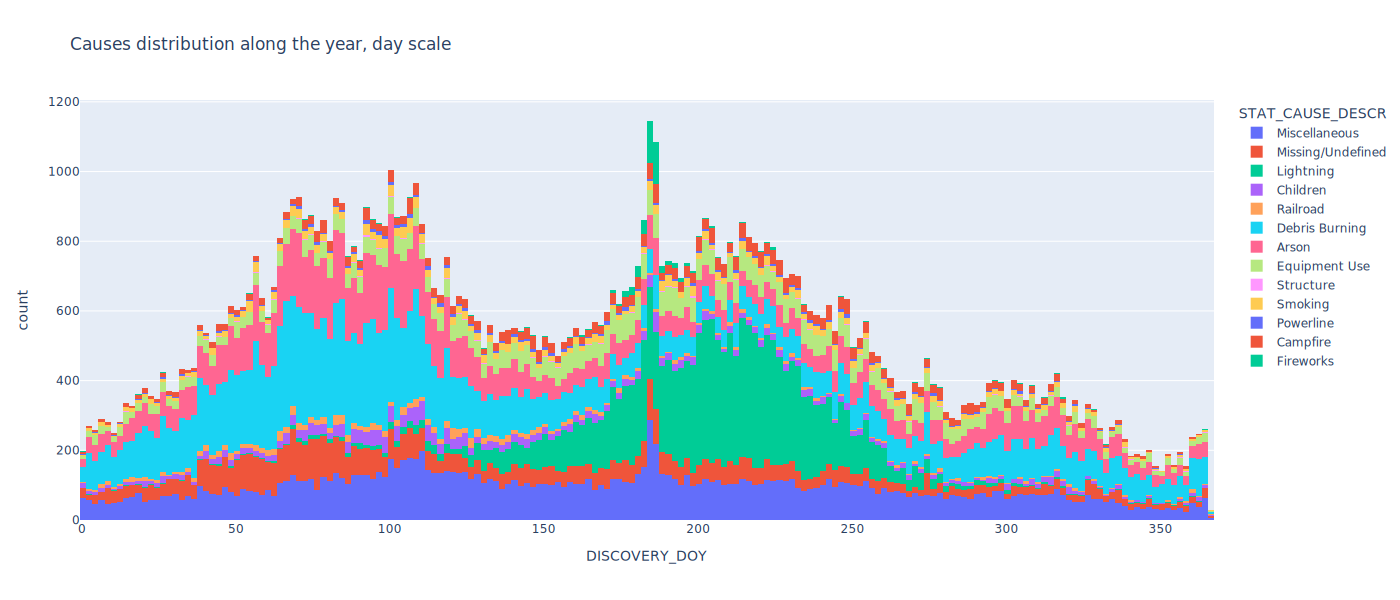

In [95]:
fig = px.histogram(df, x="DISCOVERY_DOY", color="STAT_CAUSE_DESCR",
                   title="Causes distribution along the year, day scale",
                   width=1400, height=600, nbins=365)
fig.show("svg")

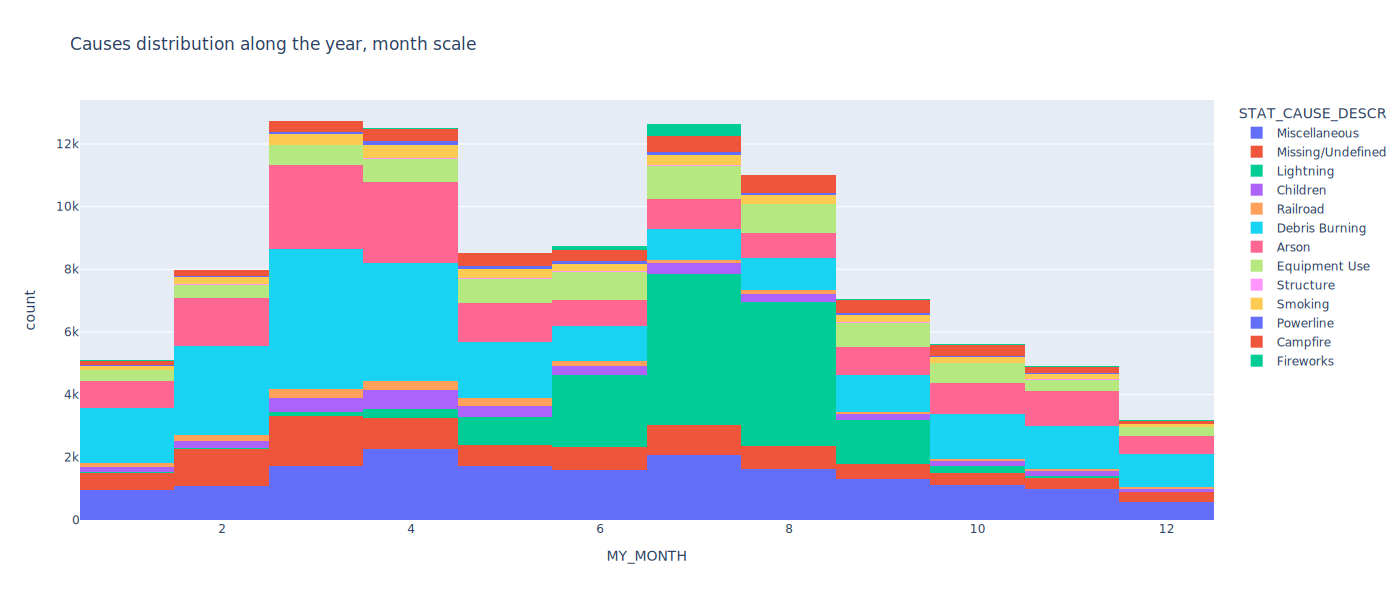

In [96]:
fig = px.histogram(df, x="MY_MONTH", color="STAT_CAUSE_DESCR",
                   title="Causes distribution along the year, month scale",
                   width=1400, height=600)
fig.show("svg")

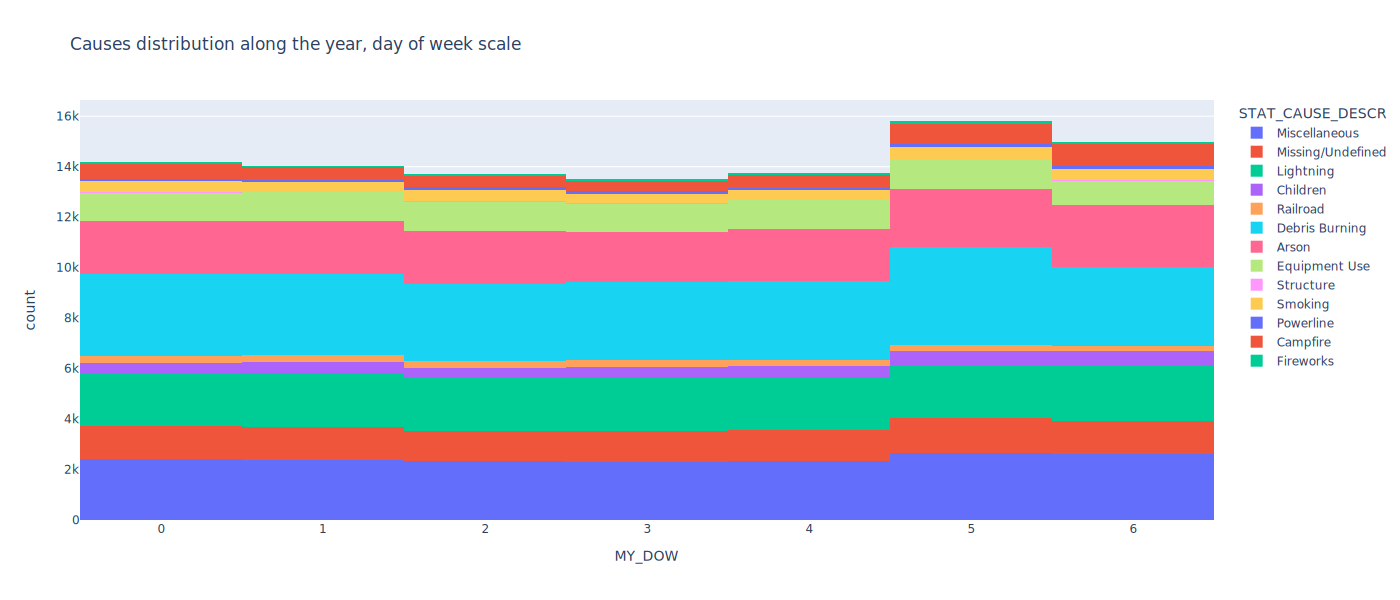

In [97]:
fig = px.histogram(df, x="MY_DOW", color="STAT_CAUSE_DESCR",
                   title="Causes distribution along the year, day of week scale",
                   width=1400, height=600)
fig.show("svg")

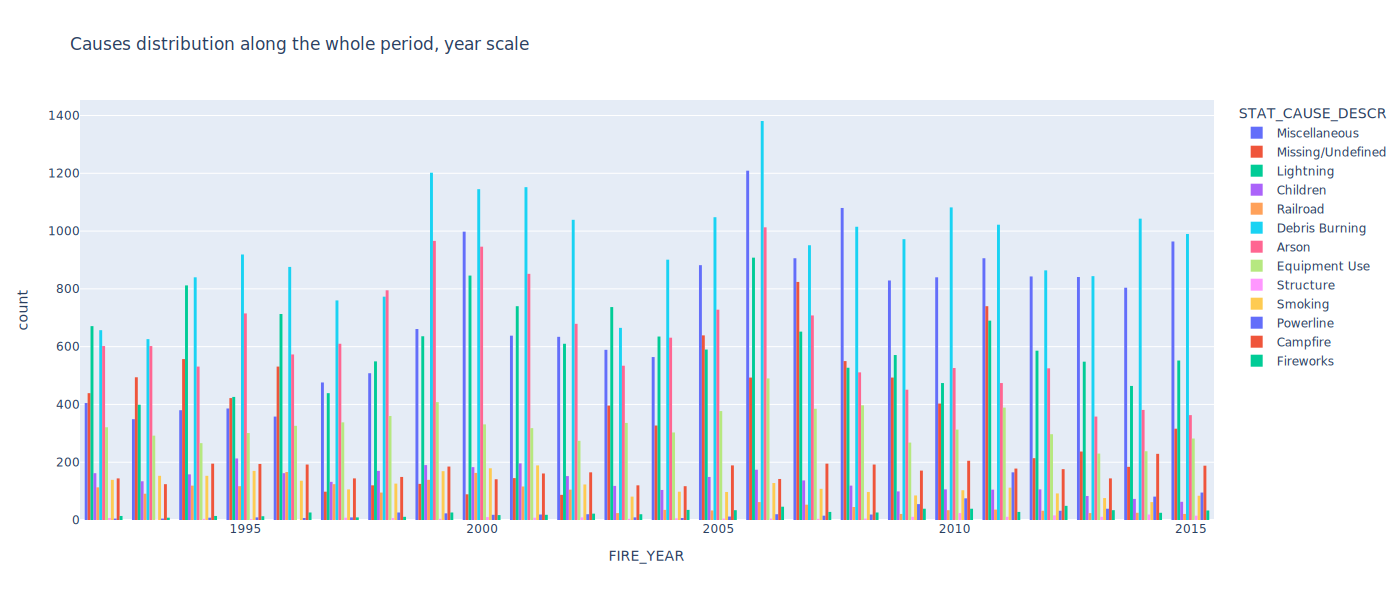

In [98]:
fig = px.histogram(df, x="FIRE_YEAR", color="STAT_CAUSE_DESCR", barmode="group",
                   title="Causes distribution along the whole period, year scale",
                   width=1400, height=600)
fig.show("svg")

#### State-size scatter

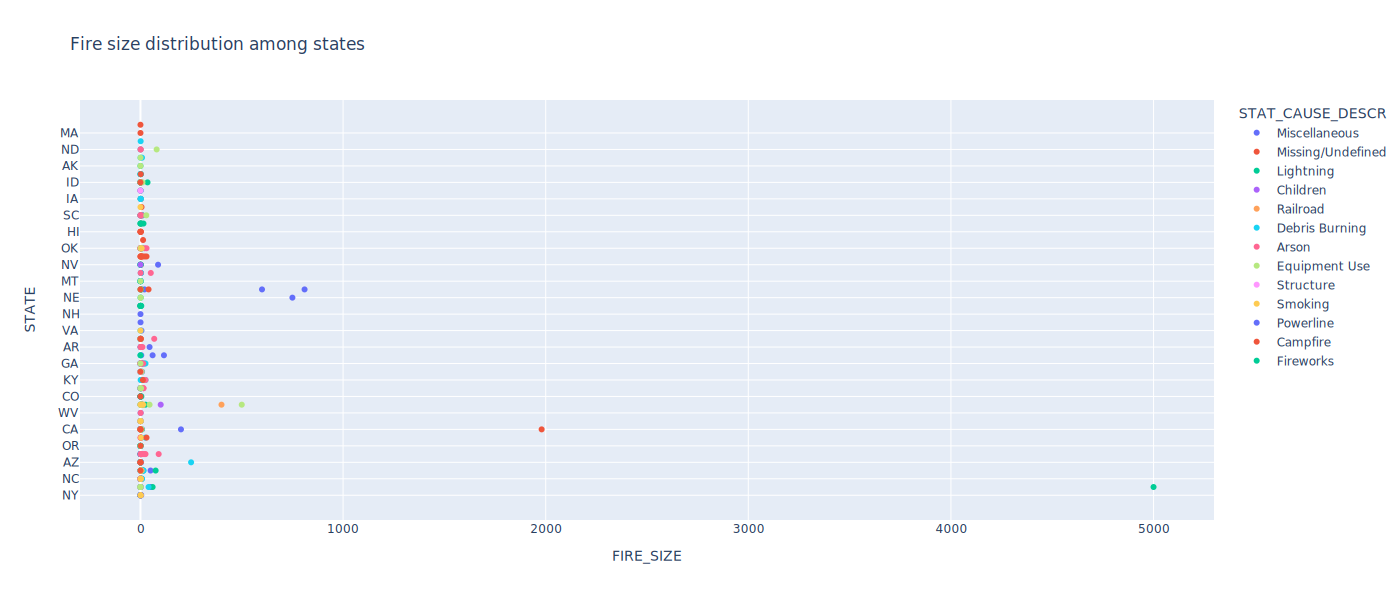

In [99]:
fig = px.scatter(df.head(500), x="FIRE_SIZE", y="STATE", color="STAT_CAUSE_DESCR",
                   title="Fire size distribution among states",
                   width=1400, height=600)
fig.show("svg")

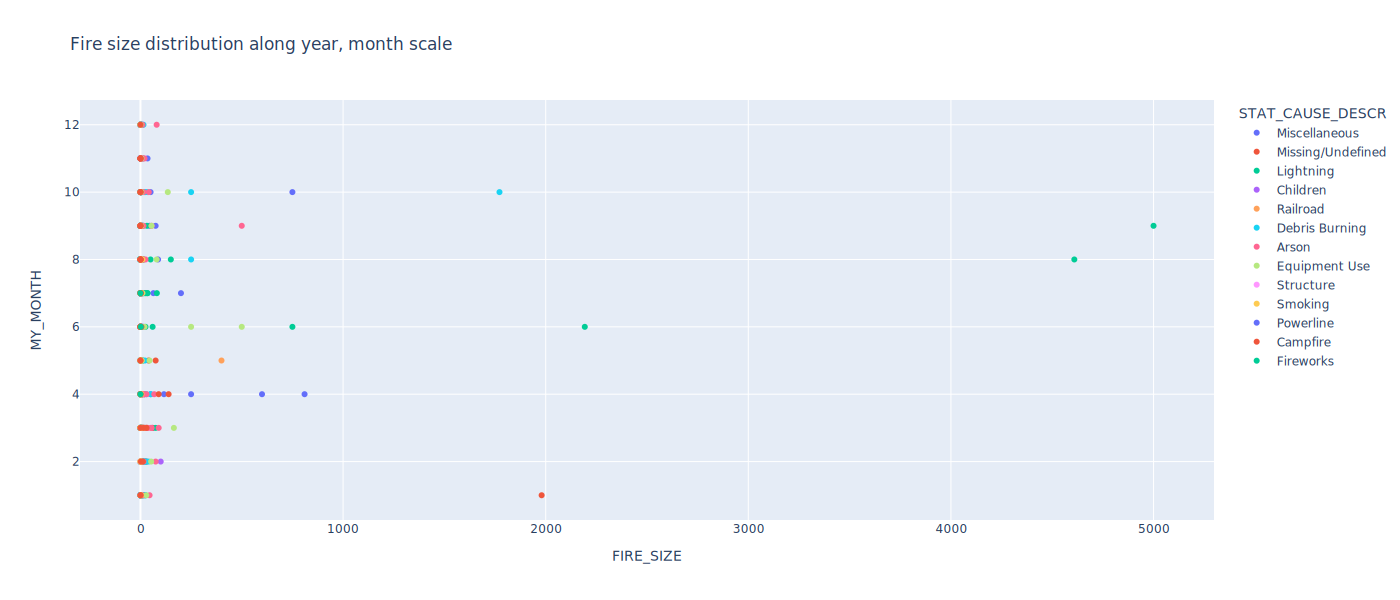

In [100]:
fig = px.scatter(df.head(1000), x="FIRE_SIZE", y="MY_MONTH", color="STAT_CAUSE_DESCR",
                   title="Fire size distribution along year, month scale",
                   width=1400, height=600)
fig.show("svg")

# Modelling

### General

In [16]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [17]:
def get_train_test(df, size=None, tr_size=None):   
    le = LabelEncoder()
    df = df[df["STAT_CAUSE_DESCR"] != "Missing/Undefined"]
    x_features = ["FIRE_SIZE", "STATE", "LATITUDE", "LONGITUDE", "FIRE_YEAR", "MY_MONTH", "DISCOVERY_DOY", "MY_DOW"]
    y_feature = ["STAT_CAUSE_DESCR"]
    X_train, X_test, y_train, y_test = train_test_split(df[x_features], df[y_feature], 
                                                        test_size=size, train_size=tr_size)
    y_train = le.fit_transform(y_train.values.reshape((-1, )))
    y_test = le.transform(y_test.values.reshape((-1, )))
    return X_train, X_test, y_train, y_test, le

In [18]:
X_train, X_test, y_train, y_test, le = get_train_test(df, size=0.2)

In [19]:
import sklearn
sklearn.set_config(display="diagram")

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.metrics import classification_report

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
X_test["RANDOM"] = np.random.normal(size=X_test.shape[0])
X_train["RANDOM"] = np.random.normal(size=X_train.shape[0])
numerical_features = ["FIRE_SIZE", "LATITUDE", "LONGITUDE", "DISCOVERY_DOY", 
                      "MY_DOW", "RANDOM"]
categorical_features = ["FIRE_YEAR", "STATE", "MY_MONTH"]
all_features = numerical_features + categorical_features

In [25]:
categories = [df_full[col].unique() for col in categorical_features[:-1]]
categories.append(list(range(1, 13)))
categories

[array([2005, 2004, 2006, 2008, 2002, 2007, 2009, 2001, 2003, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2000, 2010, 2011, 2012, 2013,
        2014, 2015]),
 array(['CA', 'NM', 'OR', 'NC', 'WY', 'CO', 'WA', 'MT', 'UT', 'AZ', 'SD',
        'AR', 'NV', 'ID', 'MN', 'TX', 'FL', 'SC', 'LA', 'OK', 'KS', 'MO',
        'NE', 'MI', 'KY', 'OH', 'IN', 'VA', 'IL', 'TN', 'GA', 'AK', 'ND',
        'WV', 'WI', 'AL', 'NH', 'PA', 'MS', 'ME', 'VT', 'NY', 'IA', 'DC',
        'MD', 'CT', 'MA', 'NJ', 'HI', 'DE', 'PR', 'RI'], dtype=object),
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]

In [26]:
categories[0].sort()

In [27]:
all_features

['FIRE_SIZE',
 'LATITUDE',
 'LONGITUDE',
 'DISCOVERY_DOY',
 'MY_DOW',
 'RANDOM',
 'FIRE_YEAR',
 'STATE',
 'MY_MONTH']

In [28]:
# fire_size=20&lat=38.06&lon=-82.16&discovery_doy=312&dow=3&random_col=0.11&fire_year=1996&month=11

In [29]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(categories=categories, handle_unknown="ignore"))
])
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)
])
preprocessor = Pipeline(steps=[
    ("data_transformer", data_transformer)
])

### Baseline

#### Naive baseline

In [118]:
import random

In [119]:
true_hits = 0
for el in y_test:
    if random.randint(0, 13) == el:
        true_hits += 1
true_hits/y_test.shape[0]

0.06960913482652613

#### Improved baseline

In [120]:
class Baseline:
    def __init__(self, a, p):
        self._a = a
        self._p = p
        
    def predict(self, x):
        return np.random.choice(a=self._a, p=self._p)

pred_vals = pd.DataFrame(y_train, columns=["y"]).value_counts(normalize=True).reset_index()
baseline = Baseline(pred_vals.iloc[:,0].values, pred_vals.iloc[:,1].values)

In [121]:
true_hits = 0
for el in y_test:
    if baseline.predict(0) == el:
        true_hits += 1
true_hits/y_test.shape[0]

0.161231884057971

### LogisticRegression

In [30]:
LR_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(multi_class="multinomial", solver="saga", C=0.6, penalty="l2"))
    # parameters were found with GridSearch
])

In [31]:
LR_pipeline.fit(X_train[all_features], y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['FIRE_SIZE',
                                                                    'LATITUDE',
                                                                    'LONGITUDE',
                                                                    'DISCOVERY_DOY',
                                                                    'MY_DOW',
                                                                    'RANDOM']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_fre...
       'AR', 'NV', 'ID', 'MN', 'TX', 'FL', 'SC', 'LA', 'OK', 'KS', 'MO',
       'NE', 'MI', 'KY', 'OH', 'IN', 'VA', 'IL', 'TN', 'GA', 'AK', 'ND',
       'WV', 'WI', 'AL', 'NH', 'PA', 'MS', 'ME', 'VT', 'NY', 'IA', 'DC',
       'MD', 'CT', 'MA', 'NJ', 'HI', 'DE', 'PR', 'RI'], dtype=object),
                                                                                                              [1,
                                                                                                               2,
                                                                                                               3,
                                                                                                               4,
                                                                                                               5,
                                                                                                               6,
                                                                                                               7,
                                                                                                               8,
                                                                                                               9,
                                                                                                               10,
                                                                                                               11,
                                                                                                               12]],
                                                                                                  handle_unknown='ignore'))]),
                                                                   ['FIRE_YEAR',
                                                                    'STATE',
                                                                    'MY_MONTH'])]))])),
                ('classifier',
                 LogisticRegression(C=0.6, multi_class='multinomial',
                                    solver='saga'))])

In [32]:
print(classification_report(y_test, LR_pipeline.predict(X_test[all_features]), zero_division=0))

              precision    recall  f1-score   support

           0       0.44      0.33      0.37      3071
           1       0.28      0.02      0.04       860
           2       0.00      0.00      0.00       656
           3       0.42      0.72      0.53      4508
           4       0.22      0.05      0.08      1599
           5       0.00      0.00      0.00       146
           6       0.53      0.77      0.62      2879
           7       0.38      0.37      0.37      3395
           8       0.00      0.00      0.00       138
           9       0.37      0.18      0.24       388
          10       0.00      0.00      0.00       556
          11       0.00      0.00      0.00        47

    accuracy                           0.43     18243
   macro avg       0.22      0.20      0.19     18243
weighted avg       0.37      0.43      0.37     18243



In [33]:
LR_pipeline["classifier"].coef_.shape

(12, 94)

In [34]:
fnames = np.array(
    numerical_features + 
    LR_pipeline["preprocessor"]["data_transformer"].transformers_[1][1]["encoder"].get_feature_names_out().tolist()
    )
coefs = np.apply_along_axis(np.sum, axis=0, arr=np.abs(LR_pipeline["classifier"].coef_))
coefs = np.vstack([fnames, coefs])

In [35]:
coefs = pd.DataFrame(coefs.transpose(), columns=["name", "value"])

In [36]:
coefs["value"] = coefs["value"].astype("float32")
coefs["value"] = np.abs(coefs["value"])

In [37]:
fig = px.bar(coefs, x="name", y="value")
# fig.add_trace(x=coefs[coefs["name"] == "RANDOM"]["value"], color="red")
fig.add_vline(x="RANDOM", line_color="red")
fig.show()

#### Model Export

In [38]:
import pickle
pfile = open("model.pkl", "ab")
pickle.dump(LR_pipeline, pfile)
pfile.close()

#### Grid search

In [39]:
LR_grid_params = {
    "classifier__C": np.arange(-5, 2, 0.1), #np.logspace(-5, 2, 200),
    "classifier__penalty": ["l1", "l2", "elasticnet"],
    "classifier__class_weight": ["balanced", None],
    
    "preprocessor__data_transformer__numerical__imputer__strategy": ["mean", "median"]
}

In [40]:
LR_search = GridSearchCV(LR_pipeline, LR_grid_params, n_jobs=-1, cv=3)

In [ ]:
LR_search.fit(X_train[all_features], y_train)

In [ ]:
print(LR_search.best_params_)

### KNeighbours

In [42]:
from sklearn.neighbors import KNeighborsClassifier

#### KN Simple

In [ ]:
KN_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5, weights="uniform",
                                        p=2, metric="minkowski"))
])

In [ ]:
KN_pipeline.fit(X_train[all_features], y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['FIRE_SIZE',
                                                                    'LATITUDE',
                                                                    'LONGITUDE',
                                                                    'DISCOVERY_DOY',
                                                                    'MY_DOW',
                                                                    'RANDOM']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_fre...
       'WV', 'WI', 'AL', 'NH', 'PA', 'MS', 'ME', 'VT', 'NY', 'IA', 'DC',
       'MD', 'CT', 'MA', 'NJ', 'HI', 'DE', 'PR', 'RI'], dtype=object),
                                                                                                              array([2005, 2004, 2006, 2008, 2002, 2007, 2009, 2001, 2003, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2010, 2011, 2012, 2013,
       2014, 2015]),
                                                                                                              [1,
                                                                                                               2,
                                                                                                               3,
                                                                                                               4,
                                                                                                               5,
                                                                                                               6,
                                                                                                               7,
                                                                                                               8,
                                                                                                               9,
                                                                                                               10,
                                                                                                               11,
                                                                                                               12]],
                                                                                                  handle_unknown='ignore'))]),
                                                                   ['STATE',
                                                                    'FIRE_YEAR',
                                                                    'MY_MONTH'])]))])),
                ('classifier', KNeighborsClassifier())])

In [ ]:
%%time
print(classification_report(
    le.inverse_transform(y_test[:10000]), 
    le.inverse_transform(KN_pipeline.predict(X_test[all_features].iloc[:10000])), 
    zero_division=0))

                precision    recall  f1-score   support

         Arson       0.32      0.43      0.37      1597
      Campfire       0.24      0.19      0.21       454
      Children       0.11      0.06      0.08       356
Debris Burning       0.43      0.52      0.47      2476
 Equipment Use       0.24      0.16      0.19       862
     Fireworks       0.32      0.18      0.23        66
     Lightning       0.64      0.74      0.69      1613
 Miscellaneous       0.45      0.39      0.42      1922
     Powerline       0.11      0.02      0.04        93
      Railroad       0.31      0.19      0.24       201
       Smoking       0.06      0.01      0.02       335
     Structure       0.00      0.00      0.00        25

      accuracy                           0.42     10000
     macro avg       0.27      0.24      0.25     10000
  weighted avg       0.39      0.42      0.40     10000

CPU times: user 2min 9s, sys: 1.44 s, total: 2min 11s
Wall time: 2min 12s


#### KN GridSearch

In [ ]:
KN_grid_params = {
    "classifier__n_neighbors": range(1, 10), 
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": np.arange(1, 5, 0.1), 
    "classifier__metric": ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 
                           'manhattan', 'precomputed'],
}

In [ ]:
KN_pipeline_ = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier())
])
KN_search = GridSearchCV(KN_pipeline_, KN_grid_params, n_jobs=-1, cv=3, verbose=3)

2022-09-29 09:24:13.697177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
%%time
KN_search.fit(X_train[all_features].iloc[:1000], y_train[:1000])

Fitting 3 folds for each of 5040 candidates, totalling 15120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2160 fits failed out of a total of 15120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/d

CPU times: user 1min 20s, sys: 1.79 s, total: 1min 22s
Wall time: 7min 47s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['FIRE_SIZE',
                                                                                           'LATITUDE',
                                                                                           'LONGITUDE',
                                                                                           'DISCOVERY_DOY',
                                                                                           'MY_DOW',
                                                                                           'RANDOM']),
                                                                                         ('categorical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           Simp...
             param_grid={'classifier__metric': ['cityblock', 'cosine',
                                                'euclidean', 'l1', 'l2',
                                                'manhattan', 'precomputed'],
                         'classifier__n_neighbors': range(1, 10),
                         'classifier__p': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9]),
                         'classifier__weights': ['uniform', 'distance']},
             verbose=3)

In [ ]:
KN_search.best_params_

{'classifier__metric': 'cityblock',
 'classifier__n_neighbors': 9,
 'classifier__p': 1.0,
 'classifier__weights': 'distance'}

In [ ]:
print(classification_report(le.inverse_transform(y_test[:10000]), 
                            le.inverse_transform(KN_search.best_estimator_.predict(X_test[all_features].iloc[:10000])), 
                            zero_division=0))

                precision    recall  f1-score   support

         Arson       0.31      0.34      0.32      1673
      Campfire       0.08      0.02      0.04       443
      Children       0.08      0.01      0.02       356
Debris Burning       0.39      0.48      0.43      2511
 Equipment Use       0.19      0.16      0.17       886
     Fireworks       0.27      0.04      0.07        74
     Lightning       0.51      0.69      0.59      1598
 Miscellaneous       0.32      0.33      0.33      1856
     Powerline       0.00      0.00      0.00        85
      Railroad       0.47      0.04      0.07       207
       Smoking       0.05      0.01      0.01       289
     Structure       0.00      0.00      0.00        22

      accuracy                           0.37     10000
     macro avg       0.22      0.18      0.17     10000
  weighted avg       0.33      0.37      0.34     10000



### RandomForest

In [ ]:
RF_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(criterion="gini", max_depth=20, min_samples_leaf=2, n_estimators=442))
    # parameters were found with GridSearch
])

In [128]:
%%time
RF_pipeline.fit(X_train[all_features], y_train)

CPU times: user 3min 21s, sys: 1.53 s, total: 3min 23s
Wall time: 3min 36s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['FIRE_SIZE',
                                                                    'LATITUDE',
                                                                    'LONGITUDE',
                                                                    'DISCOVERY_DOY',
                                                                    'MY_DOW',
                                                                    'RANDOM']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_fre...
       'NE', 'MI', 'KY', 'OH', 'IN', 'VA', 'IL', 'TN', 'GA', 'AK', 'ND',
       'WV', 'WI', 'AL', 'NH', 'PA', 'MS', 'ME', 'VT', 'NY', 'IA', 'DC',
       'MD', 'CT', 'MA', 'NJ', 'HI', 'DE', 'PR', 'RI'], dtype=object),
                                                                                                              [1,
                                                                                                               2,
                                                                                                               3,
                                                                                                               4,
                                                                                                               5,
                                                                                                               6,
                                                                                                               7,
                                                                                                               8,
                                                                                                               9,
                                                                                                               10,
                                                                                                               11,
                                                                                                               12]],
                                                                                                  handle_unknown='ignore'))]),
                                                                   ['FIRE_YEAR',
                                                                    'STATE',
                                                                    'MY_MONTH'])]))])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        n_estimators=442))])

In [129]:
print(classification_report(y_test, RF_pipeline.predict(X_test[all_features]), zero_division=0))

              precision    recall  f1-score   support

           0       0.50      0.35      0.41      2923
           1       0.49      0.07      0.12       760
           2       1.00      0.00      0.00       628
           3       0.44      0.78      0.57      4551
           4       0.41      0.10      0.16      1590
           5       0.77      0.24      0.36       113
           6       0.63      0.83      0.72      2993
           7       0.46      0.46      0.46      3460
           8       0.00      0.00      0.00       157
           9       0.40      0.30      0.35       378
          10       0.00      0.00      0.00       611
          11       0.00      0.00      0.00        52

    accuracy                           0.49     18216
   macro avg       0.43      0.26      0.26     18216
weighted avg       0.49      0.49      0.44     18216



#### GridSearch

In [ ]:
RF_grid_params = {
    "classifier__n_estimators": np.arange(436, 448, 2),
    "classifier__max_depth": np.arange(19, 26, 1),
    "classifier__min_samples_leaf": np.arange(1, 5, 1),
    "classifier__max_depth": np.arange(5, 30, 1)
    
}

In [ ]:
RF_search = GridSearchCV(RF_pipeline, RF_grid_params, n_jobs=-1, cv=3)

In [ ]:
RF_search.fit(X_train[all_features], y_train)

In [ ]:
print(RF_search.best_params_)

### Multiple RF classifiers

In [130]:
from sklearn.metrics import confusion_matrix

In [131]:
N_MODELS = 5

In [189]:
df100 = df_full.sample(n=100000)

In [190]:
df100["MY_DATE"] = df100.apply(lambda x: dt.datetime(x["FIRE_YEAR"], 1, 1) + 
                         dt.timedelta(int(x["DISCOVERY_DOY"] - 1)), axis=1)

In [191]:
df100["MY_MONTH"] = df100["MY_DATE"].apply(lambda x: x.month)

In [192]:
df100["MY_DOW"] = df100["MY_DATE"].apply(lambda x: pd.Timestamp(x).day_of_week)

In [194]:
X_train, X_test, y_train, y_test, le = get_train_test(df100, tr_size=80000)

In [200]:
X_train["RANDOM"] = np.random.normal(size=X_train.shape[0])
X_test["RANDOM"] = np.random.normal(size=X_test.shape[0])

In [195]:
from sklearn.ensemble import VotingClassifier

In [201]:
vot_clf_hard = VotingClassifier(estimators=[
    (f"RF_clf[{i}]", RandomForestClassifier(criterion="gini", max_depth=20, min_samples_leaf=2, n_estimators=100))
        for i in range(N_MODELS)
    ], voting="hard")
vot_hard_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", vot_clf_hard)
])

In [202]:
%%time
vot_hard_pipeline.fit(X_train[all_features], y_train)

CPU times: user 4min 27s, sys: 1.36 s, total: 4min 28s
Wall time: 4min 31s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['FIRE_SIZE',
                                                                    'LATITUDE',
                                                                    'LONGITUDE',
                                                                    'DISCOVERY_DOY',
                                                                    'MY_DOW',
                                                                    'RANDOM']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_fre...
                 VotingClassifier(estimators=[('RF_clf[0]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[1]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[2]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[3]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[4]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2))]))])

In [203]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(vot_hard_pipeline.predict(X_test[all_features])), zero_division=0))

                precision    recall  f1-score   support

         Arson       0.51      0.35      0.41      1889
      Campfire       0.40      0.06      0.11       493
      Children       0.57      0.01      0.02       394
Debris Burning       0.45      0.77      0.56      2849
 Equipment Use       0.31      0.05      0.09       942
     Fireworks       0.77      0.27      0.40       100
     Lightning       0.62      0.82      0.70      1882
 Miscellaneous       0.45      0.46      0.45      2051
     Powerline       0.00      0.00      0.00        86
      Railroad       0.38      0.29      0.33       203
       Smoking       0.00      0.00      0.00       357
     Structure       0.00      0.00      0.00        21

      accuracy                           0.49     11267
     macro avg       0.37      0.26      0.26     11267
  weighted avg       0.46      0.49      0.43     11267



In [204]:
vot_clf_soft = VotingClassifier(estimators=[
    (f"RF_clf[{i}]", RandomForestClassifier(criterion="gini", max_depth=20, min_samples_leaf=2, n_estimators=442))
        for i in range(N_MODELS)
    ], voting="soft")
vot_soft_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", vot_clf_hard)
])

In [205]:
%%time
vot_soft_pipeline.fit(X_train[all_features], y_train)

CPU times: user 4min 15s, sys: 1.97 s, total: 4min 17s
Wall time: 4min 17s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['FIRE_SIZE',
                                                                    'LATITUDE',
                                                                    'LONGITUDE',
                                                                    'DISCOVERY_DOY',
                                                                    'MY_DOW',
                                                                    'RANDOM']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_fre...
                 VotingClassifier(estimators=[('RF_clf[0]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[1]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[2]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[3]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2)),
                                              ('RF_clf[4]',
                                               RandomForestClassifier(max_depth=20,
                                                                      min_samples_leaf=2))]))])

In [206]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(vot_soft_pipeline.predict(X_test[all_features])), zero_division=0))

                precision    recall  f1-score   support

         Arson       0.52      0.36      0.43      1889
      Campfire       0.43      0.07      0.12       493
      Children       0.75      0.01      0.02       394
Debris Burning       0.45      0.77      0.56      2849
 Equipment Use       0.30      0.06      0.09       942
     Fireworks       0.75      0.27      0.40       100
     Lightning       0.62      0.82      0.70      1882
 Miscellaneous       0.45      0.46      0.45      2051
     Powerline       0.00      0.00      0.00        86
      Railroad       0.40      0.31      0.35       203
       Smoking       0.00      0.00      0.00       357
     Structure       0.00      0.00      0.00        21

      accuracy                           0.49     11267
     macro avg       0.39      0.26      0.26     11267
  weighted avg       0.47      0.49      0.44     11267



In [ ]:
# Thus soft voting is much better than hard voting due to higher precision 
# in children class, as it has increased more than twice comparing to hard

### XGBoost

In [43]:
import xgboost

#### Simple XGB

In [216]:
XGB_classifier = ("classifier", xgboost.XGBClassifier(
    booster="gbtree", objective="multi:softmax", 
    num_class=len(list(set(y_train))),
    # tree_method='gpu_hist', gpu_id=0,
    tree_method='hist', 
    eval_metric="mlogloss", colsample_bytree=1.0,
    max_delta_step=1.0, subsample=0.9, n_estimators=300,
    # max_depth=7, max_leaves=18, 
    grow_policy="lossguide",
    learning_rate=0.83, reg_lambda=0, reg_alpha=0, gamma=0, random_state=7575
))
XGB_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    XGB_classifier
    # parameters were found with GridSearch
])

In [217]:
%%time
XGB_pipeline.fit(X_train[all_features], y_train)

CPU times: user 54.6 s, sys: 208 ms, total: 54.8 s
Wall time: 56.1 s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['FIRE_SIZE',
                                                                    'LATITUDE',
                                                                    'LONGITUDE',
                                                                    'DISCOVERY_DOY',
                                                                    'MY_DOW',
                                                                    'RANDOM']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_fre...
                                                                                                               3,
                                                                                                               4,
                                                                                                               5,
                                                                                                               6,
                                                                                                               7,
                                                                                                               8,
                                                                                                               9,
                                                                                                               10,
                                                                                                               11,
                                                                                                               12]],
                                                                                                  handle_unknown='ignore'))]),
                                                                   ['FIRE_YEAR',
                                                                    'STATE',
                                                                    'MY_MONTH'])]))])),
                ('classifier',
                 XGBClassifier(colsample_bytree=1.0, eval_metric='mlogloss',
                               grow_policy='lossguide', learning_rate=0.83,
                               max_delta_step=1.0, n_estimators=300,
                               num_class=12, objective='multi:softprob',
                               random_state=7575, reg_lambda=0, subsample=0.9,
                               tree_method='hist'))])

In [218]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(XGB_pipeline.predict(X_test[all_features])), zero_division=0))

                precision    recall  f1-score   support

         Arson       0.50      0.44      0.46      1889
      Campfire       0.35      0.19      0.25       493
      Children       0.28      0.08      0.12       394
Debris Burning       0.47      0.67      0.56      2849
 Equipment Use       0.30      0.17      0.22       942
     Fireworks       0.59      0.40      0.48       100
     Lightning       0.68      0.83      0.74      1882
 Miscellaneous       0.45      0.45      0.45      2051
     Powerline       0.15      0.03      0.06        86
      Railroad       0.38      0.32      0.35       203
       Smoking       0.00      0.00      0.00       357
     Structure       0.00      0.00      0.00        21

      accuracy                           0.50     11267
     macro avg       0.34      0.30      0.31     11267
  weighted avg       0.46      0.50      0.47     11267



In [225]:
pd.DataFrame([XGB_pipeline["classifier"].feature_importances_],
             columns=fnames).T.sort_values(0)

0
x1_DC          0.000000
x2_12          0.003248
x1_DE          0.003412
x1_VT          0.003513
x1_MD          0.003624
x1_HI          0.004004
RANDOM         0.004061
x1_PA          0.004156
x1_OH          0.004238
x1_NH          0.004364
x1_ME          0.004590
x1_KS          0.004623
x1_NE          0.004650
x2_9           0.004829
x1_IA          0.004848
x2_4           0.004850
x1_WY          0.004887
x0_2004        0.004901
x1_IN          0.004910
x2_2           0.004922
x1_AK          0.004948
x2_3           0.004966
x1_NV          0.005065
x0_2007        0.005077
x0_2009        0.005105
x2_5           0.005185
x1_MO          0.005214
x2_10          0.005245
x1_PR          0.005295
MY_DOW         0.005302
x0_2003        0.005347
x1_IL          0.005793
x1_TN          0.005798
x0_2006        0.005815
x0_1992        0.005815
x1_MT          0.005986
x1_MN          0.006110
x0_2002        0.006248
x0_2001        0.006299
x2_1           0.006318
x0_2015        0.006328
x0_2008        0.006421
x1_VA          0.006471
x0_1998        0.006520
x1_RI          0.006602
x2_11          0.006610
x1_UT          0.006654
x0_2013        0.006746
x1_MI          0.006781
x1_SC          0.006968
x1_OR          0.006971
x0_1993        0.007074
x0_2011        0.007111
x1_AR          0.007127
x0_2010        0.007454
x0_2012        0.007483
FIRE_SIZE      0.007547
x1_MA          0.007640
x0_1999        0.007649
x1_AZ          0.007970
x1_ID          0.008159
x0_2005        0.008223
x2_8           0.008370
x1_CT          0.008436
LATITUDE       0.008741
x0_1994        0.008880
x1_NC          0.008912
x0_2000        0.009012
x1_NM          0.009336
x0_1996        0.009376
x1_WV          0.009611
x0_2014        0.009657
x2_6           0.010136
DISCOVERY_DOY  0.010457
x0_1995        0.010682
x1_SD          0.010720
x2_7           0.010721
x0_1997        0.011039
x1_CO          0.011372
x1_WI          0.011738
x1_NJ          0.011931
x1_KY          0.012148
x1_WA          0.014661
x1_LA          0.015225
x1_AL          0.015650
x1_OK          0.016375
x1_TX          0.020059
x1_GA          0.021671
LONGITUDE      0.022187
x1_ND          0.027823
x1_MS          0.028399
x1_NY          0.076835
x1_CA          0.084863
x1_FL          0.104903

#### XGB GridSearch

In [ ]:
XGB_grid_params = {
    "classifier__eval_metric": ["aucpr"], # "mlogloss"
    "classifier__subsample": [0.9],
    "classifier__colsample_bytree": [1.0],
    "classifier__max_delta_step": [1],
    "classifier__objective": ["multi:softmax"], 
    "classifier__num_class": [len(list(set(y_train)))],
    "classifier__n_estimators": [30], # 300 the best
    "classifier__max_depth": [5], # , 8, 10
    "classifier__max_leaves": [20], # 
    "classifier__grow_policy": ["lossguide"],
    "classifier__booster": ["gbtree"],
    "classifier__tree_method": ["hist"],
    # "classifier__gpu_id": [0],
    "classifier__random_state": [7575],
    "classifier__learning_rate": [0.83],
    "classifier__lambda": [0], #[0.025, 0.05], # np.logspace(-10, 10, 5, base=1.1), # l2 1.023292992280754
    "classifier__alpha": [0], # np.logspace(-10, 10, 5, base=1.1), #l1 1.023292992280754
    "classifier__gamma": [0] # np.logspace(-10, 10, 5, base=1.1) # gamma
}

In [ ]:
XGB_pipeline_ = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgboost.XGBClassifier()) 
])
XGB_search = GridSearchCV(XGB_pipeline_, XGB_grid_params, n_jobs=-1, cv=3, verbose=3)

2022-09-26 16:26:41.912936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
%%time
XGB_search.fit(X_train[all_features], y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 31.6 s, sys: 585 ms, total: 32.2 s
Wall time: 1min 29s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['FIRE_SIZE',
                                                                                           'LATITUDE',
                                                                                           'LONGITUDE',
                                                                                           'DISCOVERY_DOY',
                                                                                           'MY_DOW',
                                                                                           'RANDOM',
                                                                                           'sin6',
                                                                                           'cos6',
                                                                                           'sin12',
                                                                                           'cos12',
                                                                                           'sin16',
                                                                                           'cos16',
                                                                                           's...
                         'classifier__lambda': [0],
                         'classifier__learning_rate': [0.83],
                         'classifier__max_delta_step': [1],
                         'classifier__max_depth': [5],
                         'classifier__max_leaves': [20],
                         'classifier__n_estimators': [30],
                         'classifier__num_class': [12],
                         'classifier__objective': ['multi:softmax'],
                         'classifier__random_state': [7575],
                         'classifier__subsample': [0.9],
                         'classifier__tree_method': ['hist']},
             verbose=3)

In [ ]:
XGB_search.best_params_

{'classifier__alpha': 0,
 'classifier__booster': 'gbtree',
 'classifier__colsample_bytree': 1.0,
 'classifier__eval_metric': 'aucpr',
 'classifier__gamma': 0,
 'classifier__grow_policy': 'lossguide',
 'classifier__lambda': 0,
 'classifier__learning_rate': 0.83,
 'classifier__max_delta_step': 1,
 'classifier__max_depth': 5,
 'classifier__max_leaves': 20,
 'classifier__n_estimators': 30,
 'classifier__num_class': 12,
 'classifier__objective': 'multi:softmax',
 'classifier__random_state': 7575,
 'classifier__subsample': 0.9,
 'classifier__tree_method': 'hist'}

In [ ]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(XGB_search.best_estimator_.predict(X_test[all_features])), zero_division=0))

                precision    recall  f1-score   support

         Arson       0.51      0.42      0.46      2992
      Campfire       0.35      0.14      0.20       788
      Children       0.26      0.06      0.10       635
Debris Burning       0.47      0.71      0.56      4513
 Equipment Use       0.38      0.16      0.22      1616
     Fireworks       0.63      0.46      0.54       138
     Lightning       0.66      0.82      0.73      3018
 Miscellaneous       0.46      0.48      0.47      3463
     Powerline       0.21      0.04      0.07       142
      Railroad       0.32      0.24      0.27       322
       Smoking       0.13      0.00      0.01       548
     Structure       0.00      0.00      0.00        37

      accuracy                           0.50     18212
     macro avg       0.36      0.30      0.30     18212
  weighted avg       0.47      0.50      0.47     18212



### Stacking

In [44]:
from sklearn.ensemble import StackingClassifier

In [49]:
estimators=[
    ("xgb", xgboost.XGBClassifier(alpha=0, booster="gbtree", 
                                        colsample_bytree=1.0, 
                                        eval_metric="aucpr", 
                                        gamma=0,
                                        grow_policy="lossguide",
                                        reg_lambda=0, learning_rate=0.83,
                                        max_delta_step=1, max_depth=5,
                                        max_leaves=20, n_estimators=230,
                                        objective="multi:softmax", random_state=7575,
                                        subsample=0.9, tree_method="gpu_hist")),
    ("rf", RandomForestClassifier(criterion='gini',
                                     max_depth=20,
                                     min_samples_leaf=2,
                                     n_estimators=442)),
    ("lr", LogisticRegression(C=0.6, multi_class="multinomial", penalty="l2", solver="saga", max_iter=1000)),
    ("kn", KNeighborsClassifier(n_neighbors=5, weights="uniform", p=2, metric="minkowski")),
]

In [50]:
stacking_clf = StackingClassifier(estimators=estimators, 
    final_estimator=LogisticRegression(C=0.41, penalty="l2", solver="saga", n_jobs=-1, verbose=True, random_state=1453),
    n_jobs=-1,
    verbose=True,
)
stacking_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", stacking_clf)
])

In [51]:
stacking_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['FIRE_SIZE',
                                                                    'LATITUDE',
                                                                    'LONGITUDE',
                                                                    'DISCOVERY_DOY',
                                                                    'MY_DOW',
                                                                    'RANDOM']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_fre...
                                                               subsample=0.9,
                                                               tree_method='gpu_hist')),
                                                ('rf',
                                                 RandomForestClassifier(max_depth=20,
                                                                        min_samples_leaf=2,
                                                                        n_estimators=442)),
                                                ('lr',
                                                 LogisticRegression(C=0.6,
                                                                    max_iter=1000,
                                                                    multi_class='multinomial',
                                                                    solver='saga')),
                                                ('kn', KNeighborsClassifier())],
                                    final_estimator=LogisticRegression(C=0.41,
                                                                       n_jobs=-1,
                                                                       random_state=1453,
                                                                       solver='saga',
                                                                       verbose=True),
                                    n_jobs=-1, verbose=True))])

In [52]:
y_pred = stacking_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.44      0.49      3071
           1       0.43      0.18      0.25       860
           2       0.27      0.05      0.09       656
           3       0.48      0.72      0.58      4508
           4       0.32      0.18      0.23      1599
           5       0.58      0.29      0.38       146
           6       0.72      0.81      0.76      2879
           7       0.46      0.52      0.49      3395
           8       0.20      0.01      0.01       138
           9       0.42      0.29      0.35       388
          10       0.18      0.00      0.01       556
          11       0.00      0.00      0.00        47

    accuracy                           0.51     18243
   macro avg       0.38      0.29      0.30     18243
weighted avg       0.49      0.51      0.48     18243



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

